<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import tensorflow as tf
import numpy as np
import scipy as scp
from scipy import signal, linalg
# Solve Toeplitz Wiener
from scipy.linalg import solve_toeplitz
from numpy import asarray, array, ravel, repeat, prod, mean, where, ones
#!pip install scikits.audiolab
#!pip install --upgrade-strategy=only-if-needed git+https://github.com/Uiuran/BregmanToolkit
#!pip install scikit-image
#import scikits.audiolab as audio
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
correlate = signal.correlate
import os
import librosa


# Tensorboard display
from IPython.display import clear_output, Image, display, HTML

In [3]:
# funções auxiliares
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
# Função que usa HTML e javascript para exibir tensorboar no notebook e web
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def load_binary_tagged_data(data_path, fsa, tag='CV'):
  '''
   Data
  '''  
  nomesref = [f for f in os.listdir(data_path)]
  data_fs=[]
  nome = []
  for f in nomesref:
    data,fs = librosa.load(data_path+f,sr=None)
    if fs == fsa:
      data_fs.append(data)
      nome.append(f)
    
  return data_fs,nome

In [2]:
files = [f for f in os.listdir('/home/stattus4dpenalva/stattus4/wav_data_2018/')]
refs = [f for f in os.listdir('/home/stattus4dpenalva/stattus4/airref_wav')]
data,fs = librosa.load('/home/stattus4dpenalva/stattus4/airref_wav/'+refs[0],sr=None)
l = 135000

In [5]:
tensor_data = np.ndarray(shape=(len(files[:25]),l,1))
tensor_ref = np.ndarray(shape=(5,l,1))

for r in range(len(refs)):  
  
  data1,_ = librosa.load('/home/stattus4dpenalva/stattus4/airref_wav/'+refs[r],sr=None)
  tensor_ref[r,:,0] = data1.copy()[0:l]
  
for f in range(len(files[:25])):    
  data,_ = librosa.load('/home/stattus4dpenalva/stattus4/wav_data_2018/'+files[f],sr=None)
  tensor_data[f,:,0] = data.copy()[0:l]

In [6]:

# Comp. Graph 
graph = tf.Graph()
with graph.as_default():
  signal_in = tf.placeholder(tf.float32,(None,l,1), name='signal_in')  
  filter = tf.get_variable('filter', shape=[8000,1,1],initializer=tf.random_normal_initializer(), dtype=tf.float32)
  w = tf.get_variable('w', shape=[5,l],initializer=tf.random_normal_initializer(), dtype=tf.float32)
  signal_ref = tf.placeholder(tf.float32,(None,l,1), name='signal_ref')
  # 1D Convolve  which internally uses 2D reshaped https://www.tensorflow.org/api_docs/python/tf/nn/conv1d
  signal_out = tf.nn.conv1d(signal_in,filter,1,'SAME', name='signal_out')      
  diff = signal_in - signal_out
  loss = tf.reduce_sum(tf.math.squared_difference(diff,tf.tensordot(w,signal_ref,[[0,1],[0,1]], name='ref_contraction'), name = 'squared'), name = 'loss')
  minimize_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
  # Print operations for the graph built

  for op in graph.get_operations():
    print(op.name)
  graph_def = graph.as_graph_def()
  show_graph(graph_def)


Instructions for updating:
Colocations handled automatically by placer.
signal_in
filter/Initializer/random_normal/shape
filter/Initializer/random_normal/mean
filter/Initializer/random_normal/stddev
filter/Initializer/random_normal/RandomStandardNormal
filter/Initializer/random_normal/mul
filter/Initializer/random_normal
filter
filter/Assign
filter/read
w/Initializer/random_normal/shape
w/Initializer/random_normal/mean
w/Initializer/random_normal/stddev
w/Initializer/random_normal/RandomStandardNormal
w/Initializer/random_normal/mul
w/Initializer/random_normal
w
w/Assign
w/read
signal_ref
signal_out/ExpandDims/dim
signal_out/ExpandDims
signal_out/ExpandDims_1/dim
signal_out/ExpandDims_1
signal_out/Conv2D
signal_out/Squeeze
sub
ref_contraction/transpose/perm
ref_contraction/transpose
ref_contraction/Reshape/shape
ref_contraction/Reshape
ref_contraction/axes
ref_contraction/free
ref_contraction/Shape
ref_contraction/GatherV2/axis
ref_contraction/GatherV2
ref_contraction/GatherV2_1/axis
r

('Step:', 0, ' Loss:', 10064222.0)
('Step:', 1, ' Loss:', 8256213.5)
('Step:', 2, ' Loss:', 8666445.0)
('Step:', 3, ' Loss:', 5872809.5)
('Step:', 4, ' Loss:', 5607227.5)
('Step:', 5, ' Loss:', 6608536.5)
('Step:', 6, ' Loss:', 5977394.0)
('Step:', 7, ' Loss:', 4679100.5)
('Step:', 8, ' Loss:', 4394579.0)
('Step:', 9, ' Loss:', 4908944.5)
('Step:', 10, ' Loss:', 4903107.5)
('Mean Loss Growth ', -516111.45)
('Step:', 11, ' Loss:', 4197404.5)
('Step:', 12, ' Loss:', 3658375.5)
('Step:', 13, ' Loss:', 3754341.5)
('Step:', 14, ' Loss:', 3996985.5)
('Step:', 15, ' Loss:', 3805914.5)
('Step:', 16, ' Loss:', 3340331.5)
('Step:', 17, ' Loss:', 3115122.0)
('Step:', 18, ' Loss:', 3234494.2)
('Step:', 19, ' Loss:', 3314349.2)
('Step:', 20, ' Loss:', 3105754.0)
('Mean Loss Growth ', -347923.4)
('Step:', 21, ' Loss:', 2819303.2)
('Step:', 22, ' Loss:', 2746087.5)
('Step:', 23, ' Loss:', 2835057.2)
('Step:', 24, ' Loss:', 2818036.2)
('Step:', 25, ' Loss:', 2633197.5)
('Step:', 26, ' Loss:', 2479029.

NameError: name 'audio' is not defined

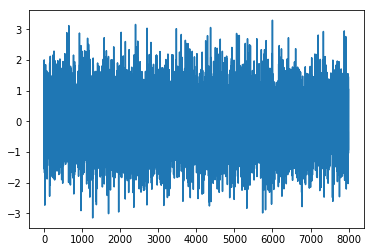

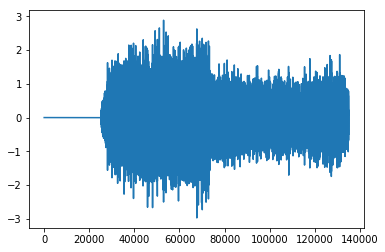

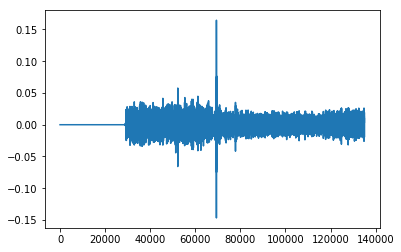

In [7]:
# Create session

with graph.as_default():
  session = tf.Session()

  feed_dict = {
      signal_in: tensor_data,
      signal_ref:tensor_ref   
  }
  options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
  run_metadata = tf.RunMetadata()
  session.run(tf.global_variables_initializer())
  lossval = np.zeros(140)
  # Perform  gradient descent steps    
  for step in range(140):
    
    loss_value = session.run(loss, feed_dict)    
    lossval[step] = loss_value

    if step % 1 == 0:
      print("Step:", step, " Loss:", loss_value)
      if step % 10 == 0 and step != 0:
        loss_diff = np.diff(lossval[np.nonzero(lossval)])
        print("Mean Loss Growth ",np.mean(loss_diff) )
    
      
    session.run(minimize_op,
                feed_dict = feed_dict,
                options=options,
                run_metadata=run_metadata)    
    
    
    # Profiling
    #fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    #chrome_trace = fetched_timeline.generate_chrome_trace_format()
    #with open('timeline_0_0_step_%d.json' % step, 'w') as f:
      #f.write(chrome_trace)

# Plot

  signal_out_value = session.run(graph.get_tensor_by_name('signal_out/Squeeze:0'), feed_dict)  
  filter_value = filter.eval(session=session)
  print('Wiener filter ')
  plt.figure()
  plt.plot(filter_value[:,0,0])    
  print('output_filter_SGD')
  plt.figure()
  plt.plot(signal_out_value[0,:,0])  
  print('input_signal')  
  plt.figure()
  plt.plot(tensor_data[0,:,0])

  audio.wavwrite( signal_out_value[0,:,0]/(np.std(signal_out_value[0,:,0],ddof=1.0)+1e-10),'/content/max_0_12072019.wav', fs=fs, enc=enc)
  
  frozen_graph = freeze_session(session, output_names= None)
  tf.train.write_graph(frozen_graph, "model", "./wiener.pb", as_text=False)   

In [10]:
i = 0
for f in files[:25]:  
  librosa.output.write_wav('./'+f, signal_out_value[i,:,0], sr=22050, norm=False)
  i += 1

In [8]:
np.shape(signal_out_value)

(25, 135000, 1)